# How and what affects the review scores of airbnb most; Price, Hosts, or Location?

Sydney Airbnb Data Listing

Karen Stevani (z5573992)

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import plotly.express as px
import contextily as ctx
from scipy.stats import pointbiserialr

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (30, 15)

In [4]:
saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to

In [5]:
#loading from file
if os.path.isfile("sydney_airbnb_listing.csv"):
    filepath = "sydney_airbnb_listing.csv"
    print("loading from file")
else:
    filepath = "https://data.insideairbnb.com/australia/nsw/sydney/2024-03-16/data/listings.csv.gz"
    print("loading from the internet")

listing_data = pd.read_csv(filepath)
print("done")

loading from file
done


Data Set: "Detailed Sydney Listings data" from insideairbnb.com

Published by: Inside Airbnb, licensed under a Creative Commons Attribution 4.0 International License, on 10 June 2024

With a total of 14274 rows and 75 columns, this dataset explores Sydney's airbnb market that has steadily started from the year of 2009 to current times. It provides information of hosts behaviors (name, id, verification, address, starting time, response rate, response time, listing count, license, and more), listing informations (price, longitude, latitude, availability, accommodation quantity, rooms and bathrooms quantity, facilities, property type and more), and various related reviews.

Sydney, a place with one of the highest housing market prices right now, is an area that is highly famous with tourism. Because of this, airbnbs play a pivotal role in providing shelter for tourists and sometimes even for longer stays of immigrants or locals in the area. Which is why through this data project, comparisons of price, host, and locations are analyzed to see the extent of their impact to one another. And mainly, if they correlate to the review scores and should affect your choice in booking an airbnb.

In [6]:
listing_data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1050164598350388320,https://www.airbnb.com/rooms/1050164598350388320,20240316023820,2024-03-18,city scrape,Self service English breakfast,Close to transport airport older style unit ne...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,211218678,...,NaN,NaN,NaN,PID-STRA-61891,f,1,0,1,0,NaN
1,1096082243192434668,https://www.airbnb.com/rooms/1096082243192434668,20240316023820,2024-03-18,city scrape,Apartment in Rushcutters Bay,Full 2 bedroom apartment with balcony. Walking...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,26721338,...,NaN,NaN,NaN,Exempt,f,2,1,1,0,NaN
2,2167538,https://www.airbnb.com/rooms/2167538,20240316023820,2024-03-18,city scrape,"Modern Sydney home near beach,shops",**Availability extremely flexible**<br /><br /...,Queens Park is a safe and friendly neighbourho...,https://a0.muscache.com/pictures/29922910/2399...,11059668,...,5.00,5.00,4.00,NaN,f,1,1,0,0,0.01
3,790607305500629830,https://www.airbnb.com/rooms/790607305500629830,20240316023820,2024-03-18,city scrape,Luxury double room,Relax in this tranquil and stylish space.,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,202112801,...,4.77,4.68,4.68,PID-STRA-21723,f,30,5,25,0,2.13
4,641106357139201992,https://www.airbnb.com/rooms/641106357139201992,20240316023820,2024-03-18,city scrape,Chic Studio Apartment in Prime Bondi Location,Immerse yourself in the vibrant atmosphere of ...,Bondi is one of Australia’s most iconic suburb...,https://a0.muscache.com/pictures/prohost-api/H...,279001183,...,3.94,4.94,4.29,PID-STRA-36651,f,217,217,0,0,0.84


In [7]:
listing_data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

#### 1. Price (Quantitative Value)

Value discussed is in relation to pricing. As potential customers, we are always looking for a reasonable trade, especially in Sydney's curent state of intense housing market. Although there are different aspects that affects pricing, such as space, facilities, location, condition, and more, this filtration process will mainly focus on standardizing all the listing price to accommodate one person's night as a benchmark.

In [8]:
listing_data.price

0        $100.00
1        $250.00
2        $650.00
3         $84.00
4        $508.00
          ...   
14269     $88.00
14270    $143.00
14271    $120.00
14272    $180.00
14273    $123.00
Name: price, Length: 14274, dtype: object

In [9]:
listing_data.accommodates

0        2
1        4
2        5
3        1
4        2
        ..
14269    2
14270    2
14271    4
14272    2
14273    2
Name: accommodates, Length: 14274, dtype: int64

In [10]:
listing_data['price'] = listing_data['price'].replace({'\$': '', ',': ''}, regex=True)
listing_data['price'] = pd.to_numeric(listing_data['price'], errors='coerce').astype('Int64')
listing_data['price'] = listing_data['price'].fillna(0).astype(int)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\karen\AppData\Local\Temp\ipykernel_16436\780121812.py:1: SyntaxWarning: invalid escape sequence '\$'
  listing_data['price'] = listing_data['price'].replace({'\$': '', ',': ''}, regex=True)


In [11]:
listing_data['standard_price'] = listing_data['price'] / listing_data['accommodates']
listing_data.standard_price

0         50.0
1         62.5
2        130.0
3         84.0
4        254.0
         ...  
14269     44.0
14270     71.5
14271     30.0
14272     90.0
14273     61.5
Name: standard_price, Length: 14274, dtype: float64

In [12]:
average_price = listing_data['price'].mean()
print(f"The average price is: ${average_price}")

average_standard_price = listing_data['standard_price'].mean()
print(f"The average price per person is: ${average_standard_price}")

The average price is: $395.94689645509317
The average price per person is: $95.22062845427966


Through taking and ensuring integer data type from the price and accommodates columns, a new column is created from the result that divides the two values together respectively. This allows a standardized price that will allow fairer comparisons. Average prices to book an airbnb in Sydney are also extracted, which is roughly \\$396 for original price and \\$95 as the average for one night's booking per person.

#### 2. Hosts

Hosts are the landlords of airbnbs. They are the owners of the airbnb property and sometimes lives in the property they are listing. There are many information categories that are provided of the host in this dataset. But for the main exploration of host's correlation to review scores and their relationship with location and price, their verification status and duration length as hosts, are the main focused column.

In [13]:
listing_data.host_identity_verified.value_counts()

host_identity_verified
t    13605
f      669
Name: count, dtype: int64

<Figure size 500x250 with 0 Axes>

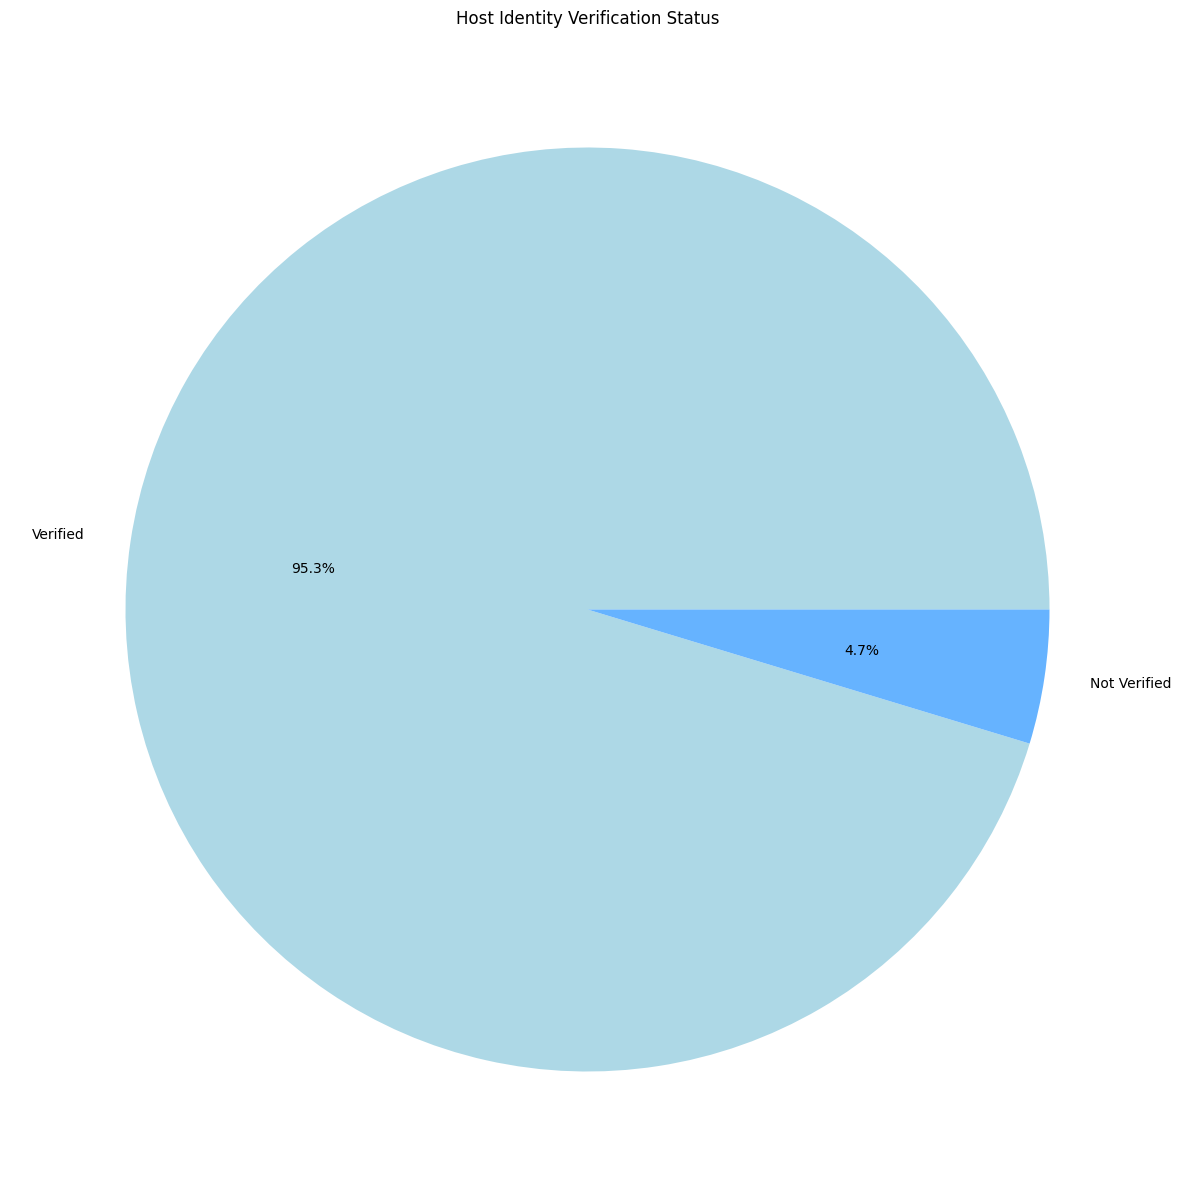

In [14]:
data = {'Status': ['Verified', 'Not Verified'], 'Count': [13605, 669]}
licensepie = pd.DataFrame(data)

plt.figure(figsize=(5, 2.5))
licensepie.set_index('Status').plot.pie(y='Count', autopct='%1.1f%%', colors=['#ADD8E6','#66b3ff'], legend=False, startangle=0)
plt.title('Host Identity Verification Status')
plt.ylabel('')
plt.show()

As seen from the chart, majority of hosts (95.3%) are verified with their host status, whereas a minority of 4.7% are not. This will be further explored later if it causes any effects on the airbnb reviews. 

In [15]:
listing_data.host_since

0        2018-08-22
1        2015-01-26
2        2014-01-06
3        2018-07-13
4        2019-07-24
            ...    
14269    2015-02-23
14270    2015-12-21
14271    2022-07-03
14272    2023-10-07
14273    2017-10-08
Name: host_since, Length: 14274, dtype: object

In [16]:
listing_data['host_since'] = pd.to_datetime(listing_data['host_since'])
date_format_pattern = "%B, %Y"
earliest_date = datetime.strftime(listing_data.host_since.min(), date_format_pattern)
latest_date = datetime.strftime(listing_data.host_since.max(), date_format_pattern)
f"The range of someone becoming an airbnb host in Sydney is {earliest_date} to {latest_date}"

'The range of someone becoming an airbnb host in Sydney is June, 2009 to March, 2024'

In [17]:
listing_data['host_since'] = pd.to_datetime(listing_data['host_since'])
reference_date = pd.Timestamp('2024-08-01')
listing_data['days_since_start'] = (reference_date - listing_data['host_since']).dt.days
listing_data.days_since_start

0        2171
1        3475
2        3860
3        2211
4        1835
         ... 
14269    3447
14270    3146
14271     760
14272     299
14273    2489
Name: days_since_start, Length: 14274, dtype: int64

In [18]:
average_age_as_host = listing_data['days_since_start'].mean()
print(f"The average duration someone has become an airbnb host in Sydney is {average_age_as_host} days")

The average duration someone has become an airbnb host in Sydney is 2615.159030404932 days


After calculations, the average duration someone has become an airbnb host in Sydney is 2622.159030404932 days or roughly about 7 years, 2 months, and 5 days. Meaning most airbnb hosts started listing around 2017. The new calculated column of how long (in terms of days) each person has become an airbnb host in Sydney (with 1st August 2024 as calculation reference), allows creation of graphs comparing host to other sections and review scores.

#### 3. Location

In [19]:
fig = px.scatter_mapbox(listing_data, 
                        lat='latitude', 
                        lon='longitude',
                        title='Interactive Sydney Airbnb Map',
                        mapbox_style="carto-positron",
                        zoom=10)
fig.show()

Through the help of plotly express module, the scatter_mapbox function graphed the location of all the airbnbs with longitude and latitude values. Seen from the map, Sydney airbnbs location are quite evenly distributed. However, it is most concentrated around the are of Darlinghurst, Haymarket, Bondi, Manly Beach and Mona Vale. This shows that even when renting airbnbs originally stemmed from an attempt to earn a little more money, unlike back in 2009 however, it has become quite a serious and growing industry. Similar to hotels, they target more famous and tourist centric locations now.

#### Correlations in Between

##### Price and Host Verification

In [22]:
verified_hosts = listing_data[listing_data['host_identity_verified'] == 'yes']
non_verified_hosts = listing_data[listing_data['host_identity_verified'] == 'no']

In [23]:
filtered_price = listing_data[(listing_data['standard_price'] >= 0) & (listing_data['standard_price'] <= 200)] 
#as average for standard price is $95, range of 0-200 allows more detailed analysis whilst keeping a balanced range of values below and above average

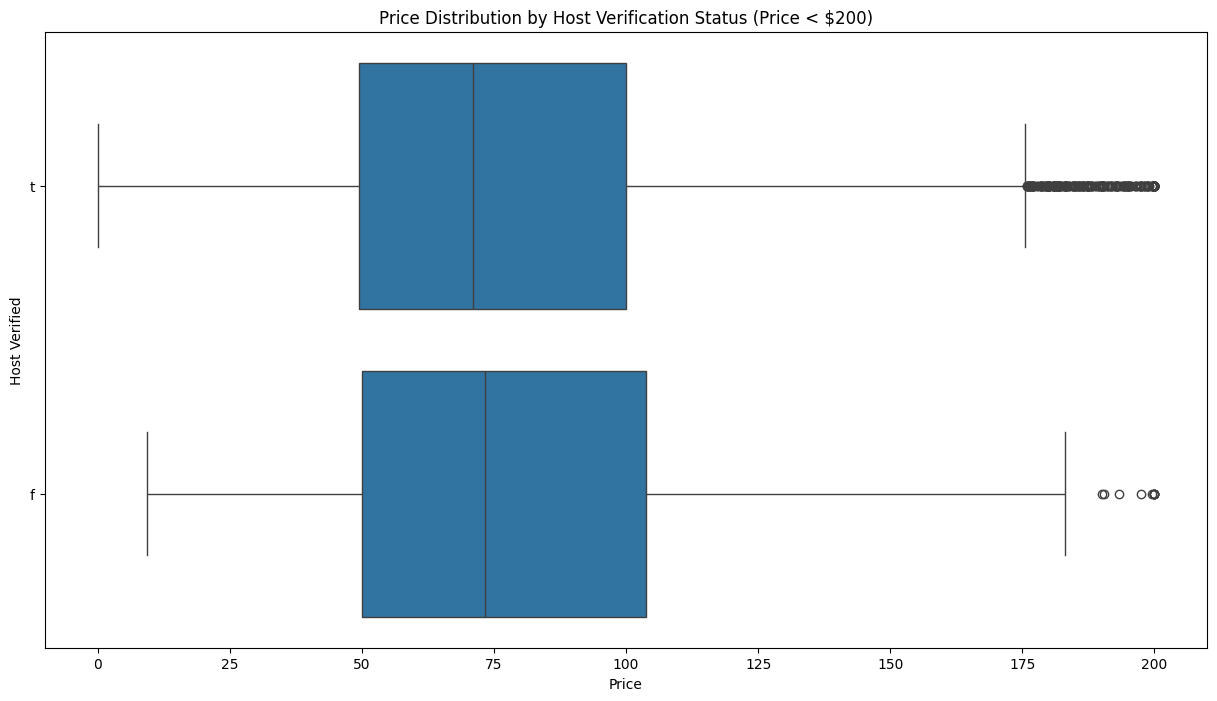

In [24]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='standard_price', y='host_identity_verified', data=filtered_price)
plt.title('Price Distribution by Host Verification Status (Price < $200)')
plt.xlabel('Price')
plt.ylabel('Host Verified')
plt.show()

From the box and whiskers graph of price distribution with host verification status, we can see that a host's status doesn't really affect the price of airbnbs. The difference is miniscule, although suprisingly with host verified having lower price median and range overall. However as seen above, there are more outliers in the verified bar. So with the nature of box and whiskers that analyze about 50% or more of where data falls, but not all, this doesn't necessarily shows the true average price distribution per person. Considering for this dataset, still a huge number of real existing prices of perhaps fancier listings, are deemed as immediate outliers. Which is why when average price is calculated and compared, a verified host still holds a higher value than a non verified host, although not by a lot. 

The outcome of graph above could also be affected due to the bigger range of verified host (95.3%) compared to the non verified (4.7%), meaning percentage of finding listings with lower prices are more likely in the bigger data pool.

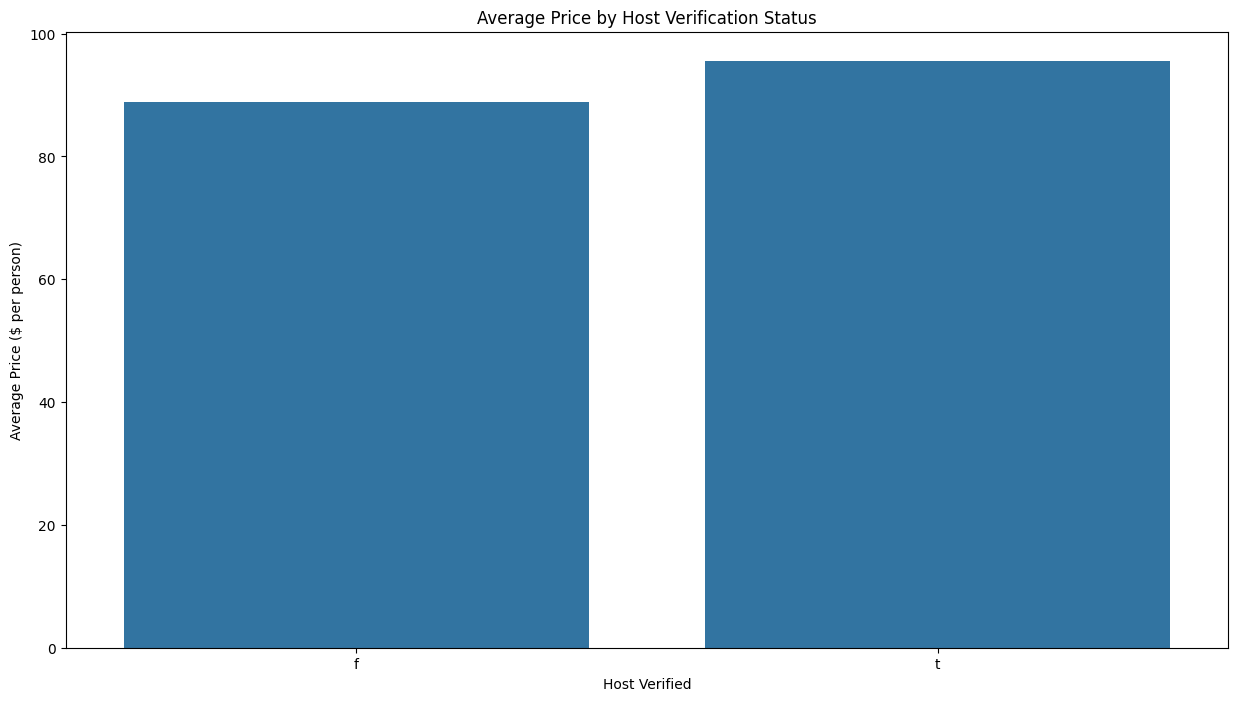

In [28]:
mean_prices = listing_data.groupby('host_identity_verified')['standard_price'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x='host_identity_verified', y='standard_price', data=mean_prices)
plt.title('Average Price by Host Verification Status')
plt.xlabel('Host Verified')
plt.ylabel('Average Price ($ per person)')
plt.show()

##### Price and Hosts' Active Days

In [26]:
def nearest_multiple_of_100(x):
    return (x // 100) * 100

listing_data['duration_multiple_of_100'] = listing_data['days_since_start'].apply(nearest_multiple_of_100)
average_price_by_duration = listing_data.groupby('duration_multiple_of_100')['standard_price'].mean().reset_index()
average_price_by_duration.columns = ['Duration (Days Multiple of 100)', 'Average Price']
print(average_price_by_duration)

    Duration (Days Multiple of 100)  Average Price
0                               100      71.330116
1                               200     139.547254
2                               300      72.132421
3                               400      72.959692
4                               500      73.143014
5                               600      94.887738
6                               700      73.314745
7                               800      74.111902
8                               900      75.453864
9                              1000      89.312608
10                             1100      85.797861
11                             1200      91.157850
12                             1300      78.362602
13                             1400      86.829747
14                             1500      98.513473
15                             1600      94.261619
16                             1700      85.856558
17                             1800      84.468748
18                             

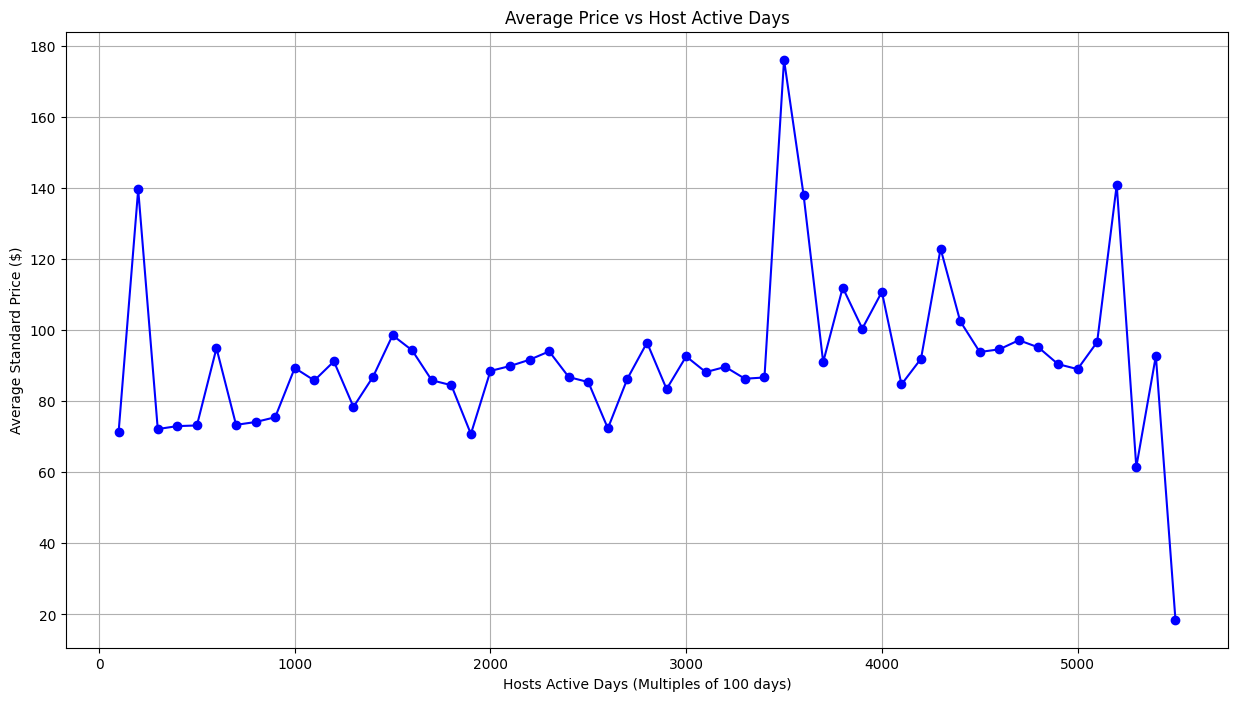

In [29]:
def active_price():
    
    plt.figure(figsize=(15, 8))
    plt.plot(
    average_price_by_duration['Duration (Days Multiple of 100)'], 
    average_price_by_duration['Average Price'], 
    marker='o', 
    linestyle='-', 
    color='b'
    )
    plt.xlabel('Hosts Active Days (Multiples of 100 days)')
    plt.ylabel('Average Standard Price ($)')
    plt.title('Average Price vs Host Active Days')
    plt.grid(True)
    plt.show()

active_price()

Next, from this line graph, we can see that unexpectedly, people that have become hosts for 100 (3 months), 3500 (9 years and 7 months), 3600 (9 years and 10 months) and 5200 (14 years and 2 months) days set significantly higher prices than others. The prices average about \\$140 per person for a night, which is about \\$20 more expensive than the second highest price after and about \\$40 more expensive than the average prices of others.

Some of the most drastic change are also prevelant in an increase between people that just started becoming host to people who have been hosts for 3 months, with a massive \\$70 jump. This may be due to new hosts being unfamiliar to the average prices in the market and concerns of renting possibilities over competitors with their newer experience. Afterwards, the increase perhaps shows their risk taking and assurance of price setting from the market's reference. Contrastingly, one of the lowest drop in price is seen from older hosts (from 14 years and 9 months to 15 years), with a drop of \\$70. This may be due to their consequently older property condition, serving less value for listing. 

Although there really isn't a clear pattern of price increase or decline throughout hosts' active days, it is notable that the lowest prices are set by hosts that started for less than 3 months or closer to 15 years. Hence, as customers on a budget, targeting these two range might be best. Although obviously this neglects the living condition and host service, which may be better for hosts that set higher prices. Which is why review scores will be further explored later on this aspect to see if quality difference is not massive enough to sacrifice for price.

##### Price and Location

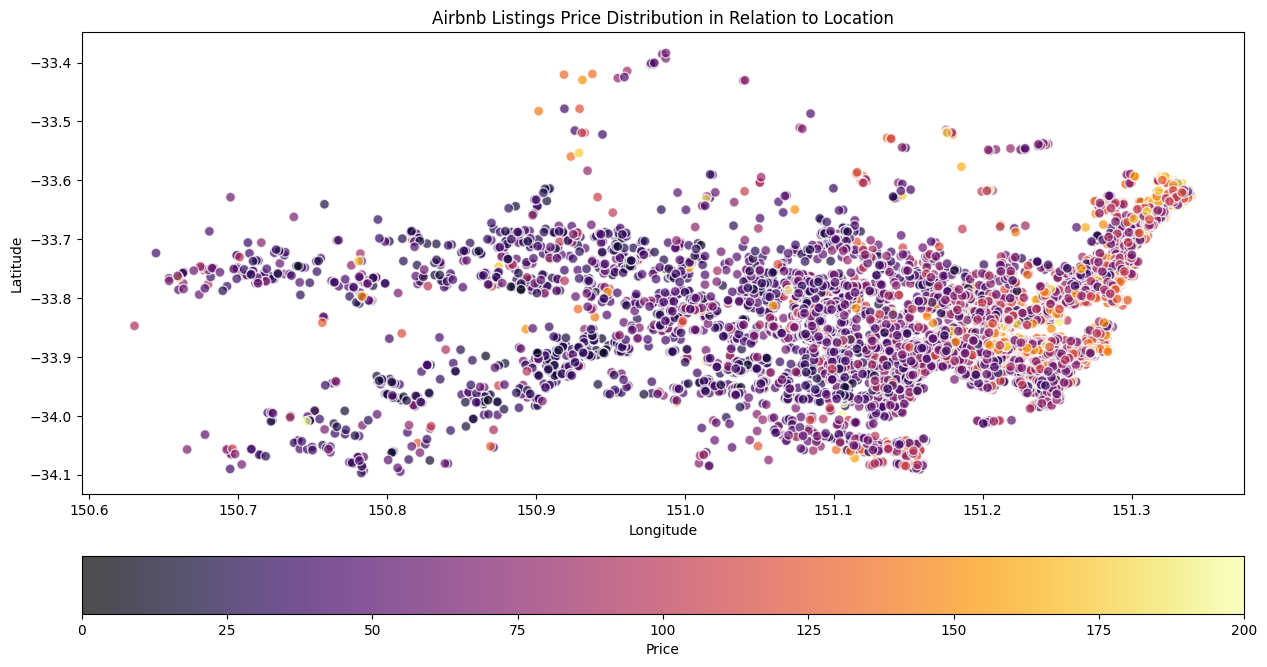

In [30]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = ax.scatter(
    filtered_price['longitude'], 
    filtered_price['latitude'], 
    c=filtered_price['standard_price'], 
    cmap='inferno', 
    s=50, 
    alpha=0.7, 
    edgecolors='w'
)

cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, ax=ax)
cbar.set_label('Price')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Airbnb Listings Price Distribution in Relation to Location')
plt.show()

Next, for price and location correlation (still utilizing \\$0-\\$200 range for clearer and more detailed distribution), we can see that more brighter plots are seen near the coastlines. This could be due to several reasons, such as:
1. It is closer to tourist attractions, hence demand is higher
2. There are more scenic views and is closer to nature, which is one of the reason for Sydney's fame
3. Closer to areas that facilitate more activities (surfing and more)
4. It's harder to maintain as land can be lost to the ocean and property is more fragile and may erode easily (or material cost is higher for initial building)
5. Price market is higher, stemming since age old history where properties near beaches are more desired due to its heavy and more accessible trade environment 

##### Hosts' Active Days and Location

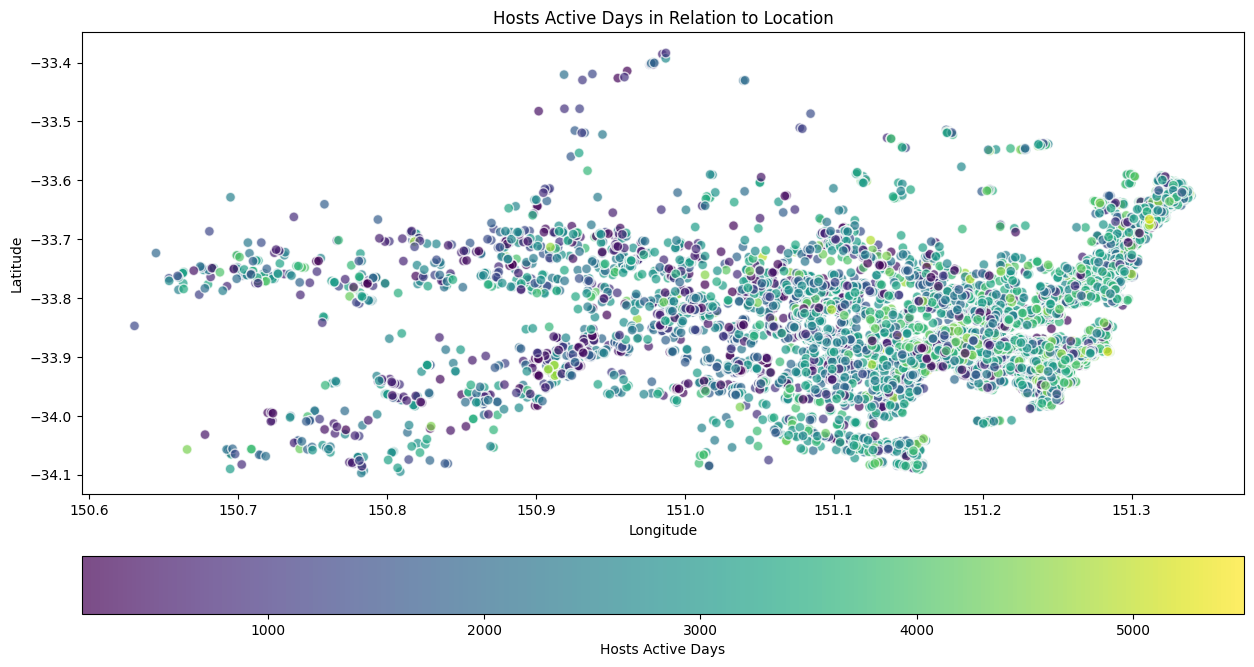

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = ax.scatter(
    filtered_price['longitude'], 
    filtered_price['latitude'], 
    c=filtered_price['days_since_start'], 
    cmap='viridis', 
    s=50, 
    alpha=0.7, 
    edgecolors='w'
)

cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, ax=ax)
cbar.set_label('Hosts Active Days')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Hosts Active Days in Relation to Location')
plt.show()

Old and new airbnb hosts in Sydney are again quite evenly distributed in location. However notably from the graph, areas near the coasts, which were analyzed before to have higher prices, are mostly listed by hosts that started 6 years and 10 months ago, which tends to list propereties for average of \\$80-\\$100. Hosts that have been renting for more than 5000 days and were established before to set significantly cheaper prices, are also found in these beach coasts. Which shows that although airbnb price market tends to be higher there, a few airbnbs that are some of the cheapest in entirety of Sydney are located near too. Aside from that, most listings in the southern area has hosts leasing for 2000-3000 days (5 years and 5 months to 8 years and 2 months) and trends of newer hosts can be seen as airbnb locations get closer to the west parts.

#### Their effects on Review Scores

Now that we have seen their trends with each other, let us analyze these four categories to its correlation with review scores. With assumptions that review scores provide reliability for renting quality, we can see whether any of these aspects should be considered when booking an airbnb based on their correlation strength.

In [32]:
listing_data.review_scores_rating

0         NaN
1         NaN
2        4.00
3        4.71
4        4.00
         ... 
14269    4.57
14270    4.87
14271    4.96
14272     NaN
14273    4.98
Name: review_scores_rating, Length: 14274, dtype: float64

In [33]:
listing_data['review_scores_rating'] = pd.to_numeric(listing_data['review_scores_rating'], errors='coerce')
average_review_score = listing_data['review_scores_rating'].mean()
print(f'Average review score is {average_review_score} out of 5')

Average review score is 4.711222399462682 out of 5


##### Price and Rating

C:\Users\karen\AppData\Local\Temp\ipykernel_28228\2424725215.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



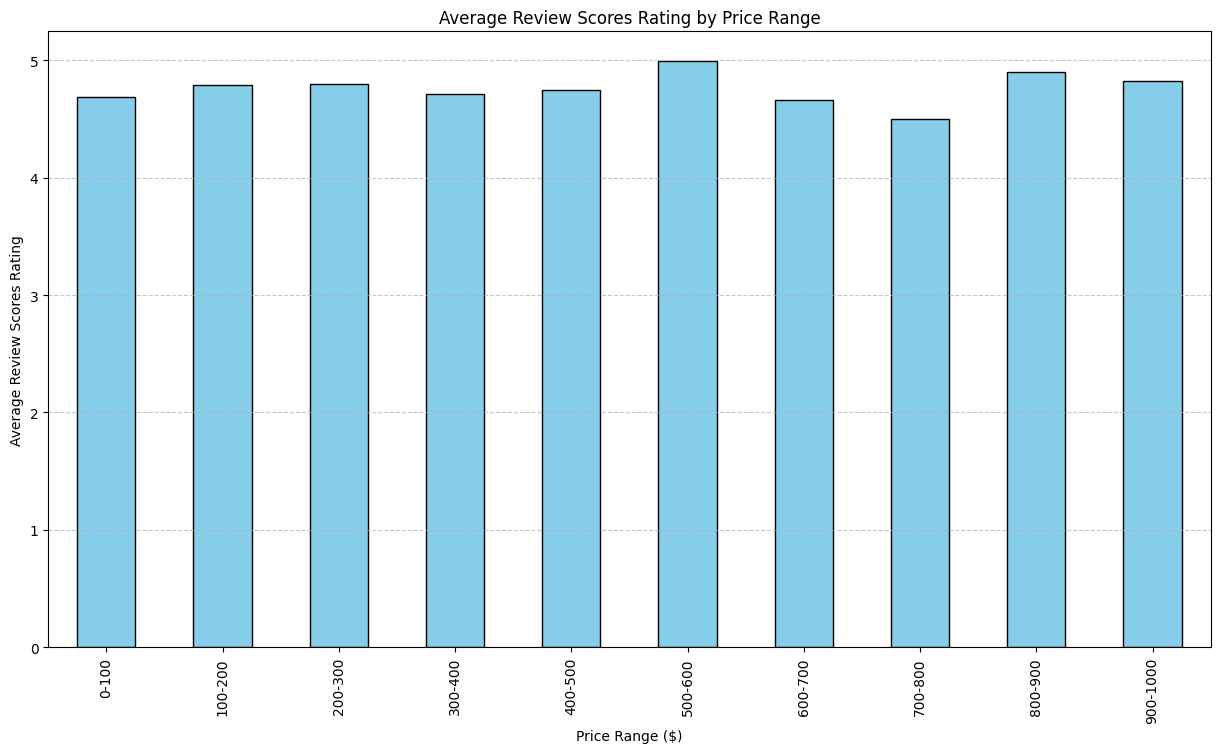

In [34]:
price_bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
price_labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900', '900-1000']

listing_data['price_range'] = pd.cut(listing_data['standard_price'], bins=price_bins, labels=price_labels, include_lowest=True)
avg_review_scores = listing_data.groupby('price_range')['review_scores_rating'].mean()

fig, ax = plt.subplots(figsize=(15, 8))
avg_review_scores.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Price Range ($)')
ax.set_ylabel('Average Review Scores Rating')
ax.set_title('Average Review Scores Rating by Price Range')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As seen from above, there really isn't a set pattern of increasing price equating increasing quality. However \\$500-600 prices seems to have the highest rating and \\$700-800 seems to be the price range to avoid, because the rating doesn't reflect its absurd value. Now as my project has been focusing on \\$0-200 standard prices, I'll zoom the graph and refer back to the filtered price with upper bound of \\$200. 

C:\Users\karen\AppData\Local\Temp\ipykernel_28228\1252188352.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\karen\AppData\Local\Temp\ipykernel_28228\1252188352.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



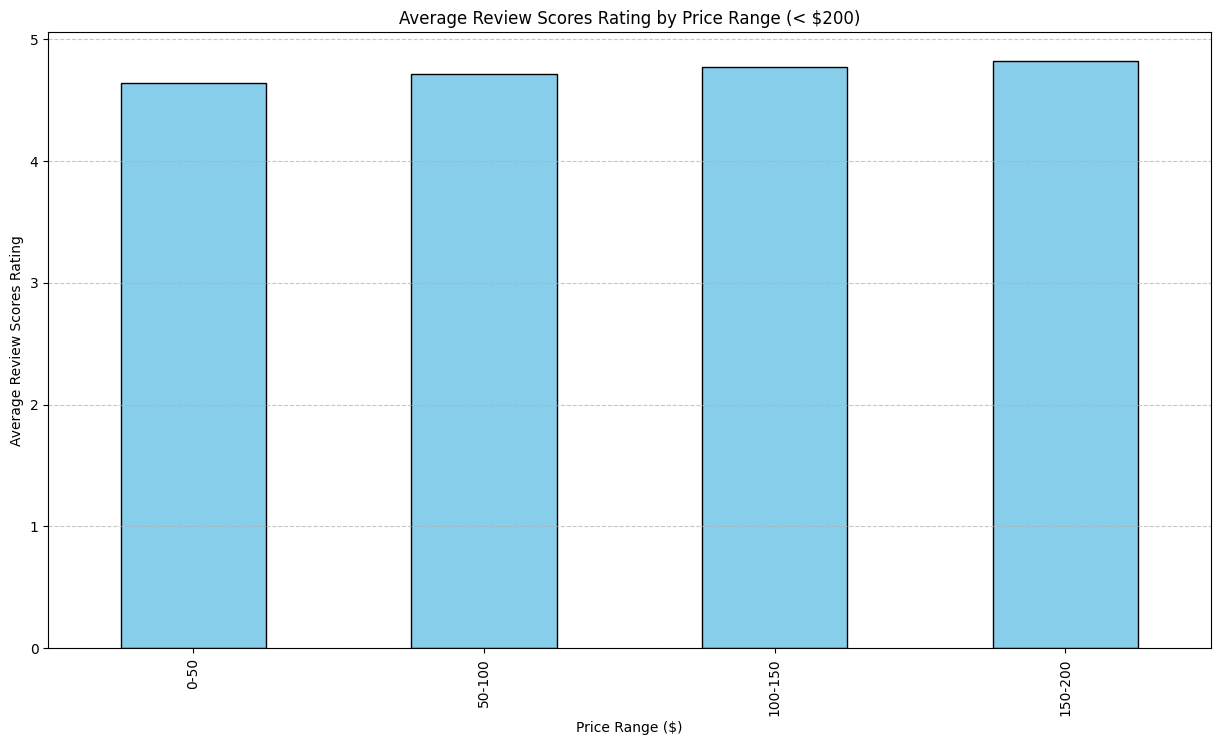

In [35]:
price_bins = [0, 50, 100, 150, 200]
price_labels = ['0-50', '50-100', '100-150', '150-200']

filtered_price['price_range'] = pd.cut(filtered_price['standard_price'], bins=price_bins, labels=price_labels, include_lowest=True)
avg_review_scores = filtered_price.groupby('price_range')['review_scores_rating'].mean()

fig, ax = plt.subplots(figsize=(15, 8))
avg_review_scores.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Price Range ($)')
ax.set_ylabel('Average Review Scores Rating')
ax.set_title('Average Review Scores Rating by Price Range (< $200)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

With the filtered standard price, there seems to be a slight upwards trend for every increase of \$50 group range. However, the difference isn't a lot and still all fall under 4.5-5 stars rating score. Hence this shouldn't affect your final booking decision, and initial desired budget goal should just be referred instead. 

##### Host Verification and Rating

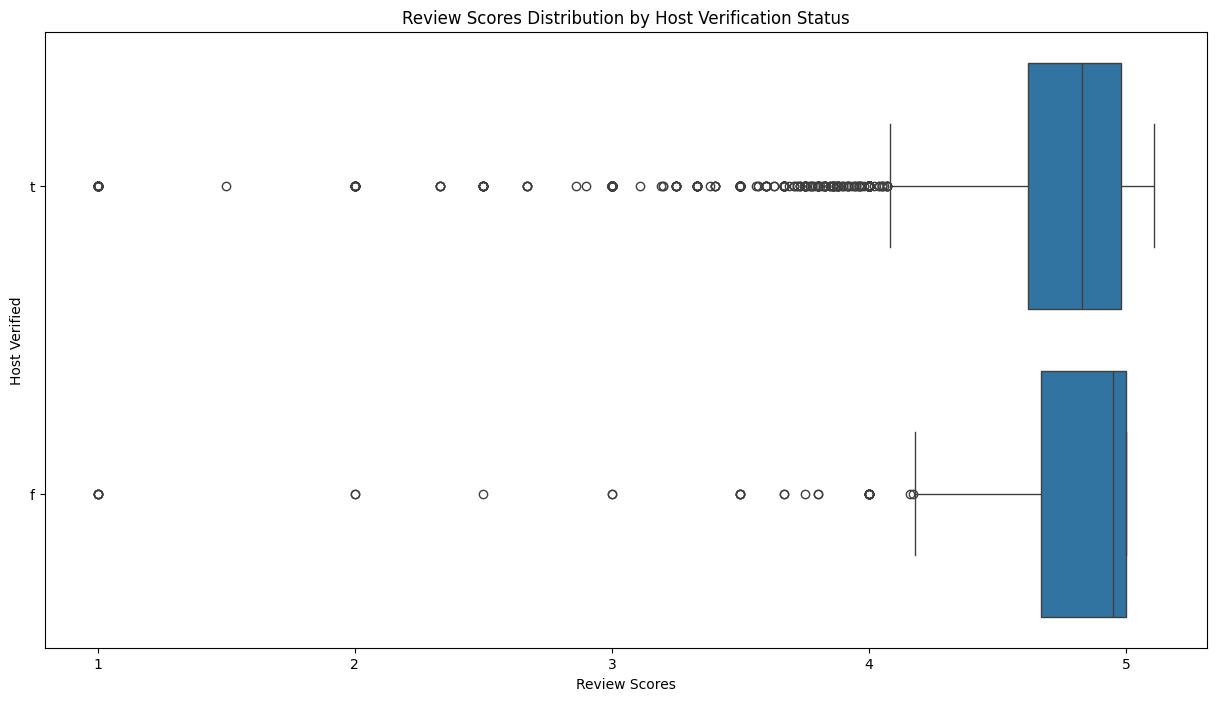

In [37]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='review_scores_rating', y='host_identity_verified', data=listing_data)
plt.title('Review Scores Distribution by Host Verification Status')
plt.xlabel('Review Scores')
plt.ylabel('Host Verified')
plt.show()

Suprisingly, as shown from the graph above, unverified hosts have a slightly higher range and median for review scores rating. They also have less assumed outliers by python compared to the verified ones. Again, this may be due to the smaller data pool with only 4.7%  of the entire Sydney airbnb hosts. This goes to show that even with a slightly higher average price range compared to verified hosts from before, unverified hosts are not an unreliable alternative to opt for.

##### Hosts Active Days and Rating

In [36]:
def nearest_multiple_of_100(x):
    return (x // 100) * 100

listing_data['duration_multiple_of_100'] = listing_data['days_since_start'].apply(nearest_multiple_of_100)
average_rating_by_duration = listing_data.groupby('duration_multiple_of_100')['review_scores_rating'].mean().reset_index()
average_rating_by_duration.columns = ['Duration (Days Multiple of 100)', 'review_scores_rating']
print(average_rating_by_duration)

    Duration (Days Multiple of 100)  review_scores_rating
0                               100              4.766531
1                               200              4.509442
2                               300              4.612905
3                               400              4.678875
4                               500              4.639880
5                               600              4.642159
6                               700              4.603052
7                               800              4.759134
8                               900              4.746000
9                              1000              4.612062
10                             1100              4.661277
11                             1200              4.706173
12                             1300              4.719388
13                             1400              4.698061
14                             1500              4.545304
15                             1600              4.657449
16            

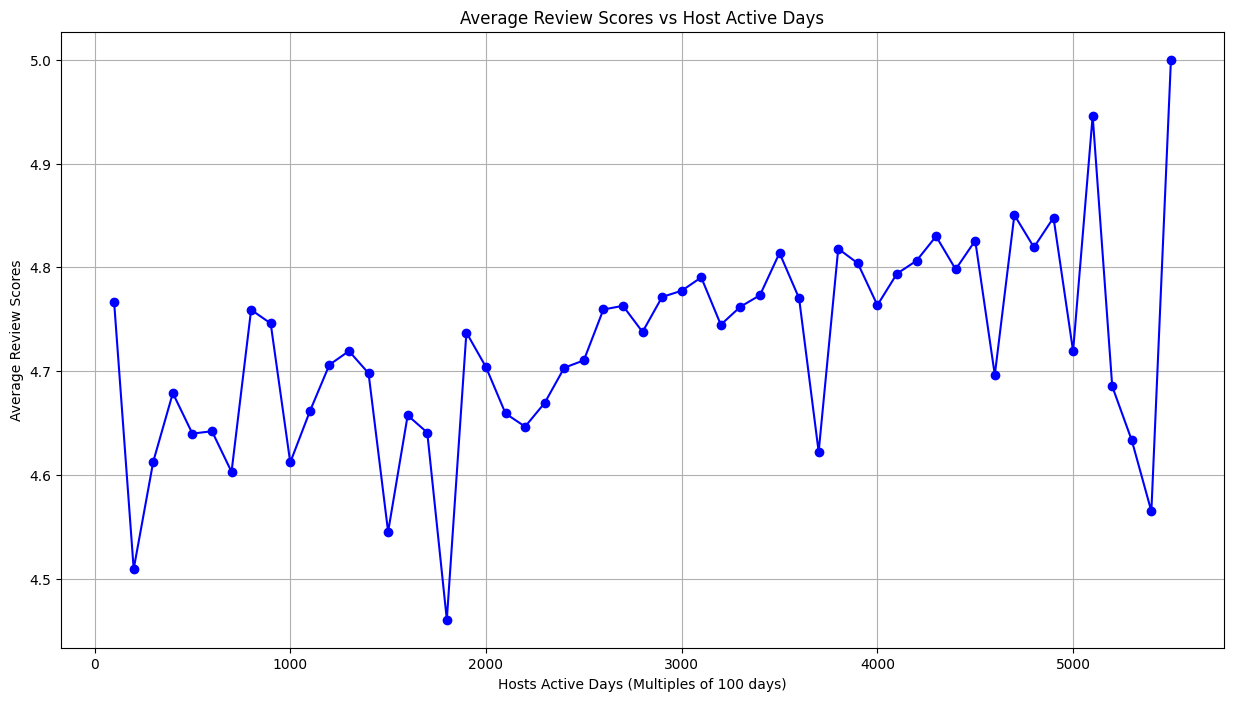

In [38]:
plt.figure(figsize=(15, 8))
plt.plot(
    average_rating_by_duration['Duration (Days Multiple of 100)'], 
    average_rating_by_duration['review_scores_rating'], 
    marker='o', 
    linestyle='-', 
    color='b'
)
plt.xlabel('Hosts Active Days (Multiples of 100 days)')
plt.ylabel('Average Review Scores')
plt.title('Average Review Scores vs Host Active Days')
plt.grid(True)
plt.show()

The trends of hosts' active days compared to the average review scores, provides an interesting insight. Because when we refer back to hosts' active days against prices (code copied below for direct reference), the plot patterns are almost opposite of each other. This is especially prevelant in the first two plots and the last four. Hosts that are active for 3 months and less have a high average rating between 4.7 and 4.8 despite setting an average price of about \\$70, compared to 3-6 months active hosts that set a higher average price of \\$140 with review scores just a little above 4.5. These two aspects might've directly affected each other, in a way that customers renting from 3-6 months old hosts having higher expectations of listings due to their higher price, and from the unmet expectations, consequently rate the place lower.

Analyzing the last four points, booking through 13 years 8 months - 13 years 11 months active host is more encouraged than a 13 years 11 months - 14 years 2 months active host. Not only are the ratings for these listings higher by 0.27 score, the prices are also cheaper by \\$45 per person a night. Lastly, hosts that have been active from 14 years and 9 months to 15 years show the most promising listing. They have the lowest average price range (\\$20-\\$90) and highest average rating (5/5).

Out of all the aspects against review scores, hosts' active days has shown the most correlation. Aside from the clear rating drop for 100-200 days host, 700-800 days host, and the gradual up and down values, there seem to be a positive trend. Meaning, the chances of getting higher quality services and valued airbnbs are higher when opting to book with a host that has been in the industry for longer.

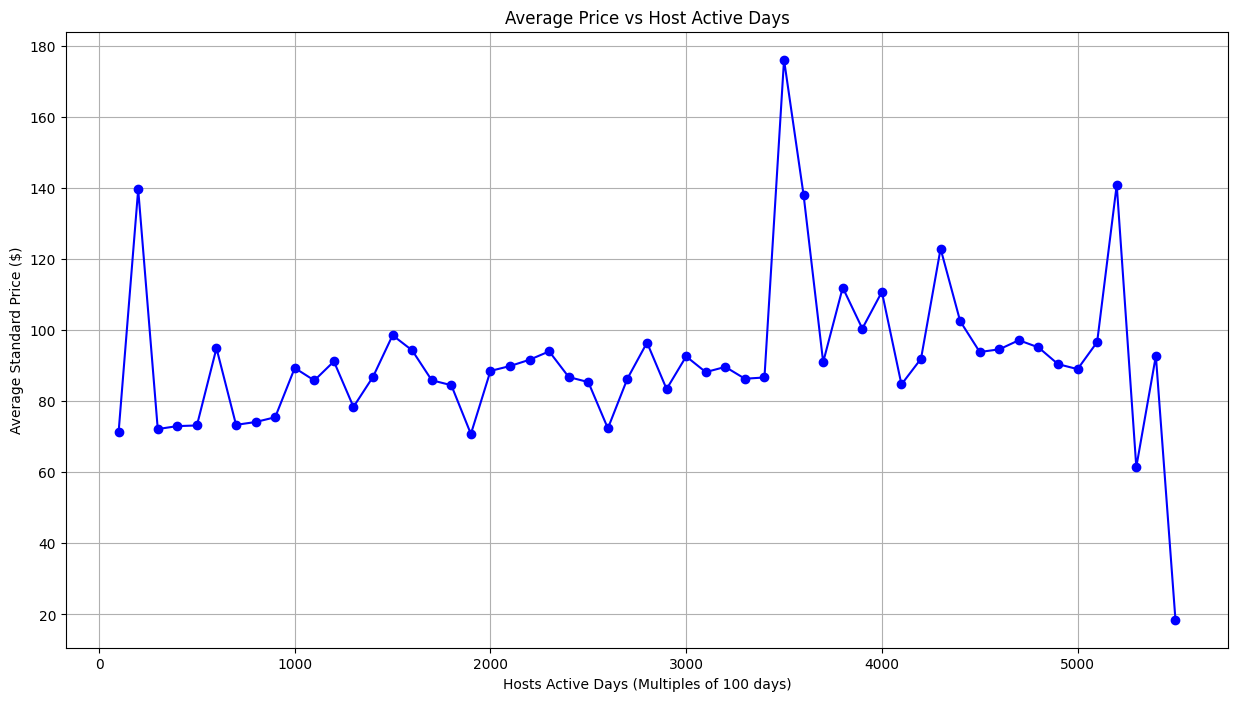

In [39]:
active_price()

##### Location and Rating

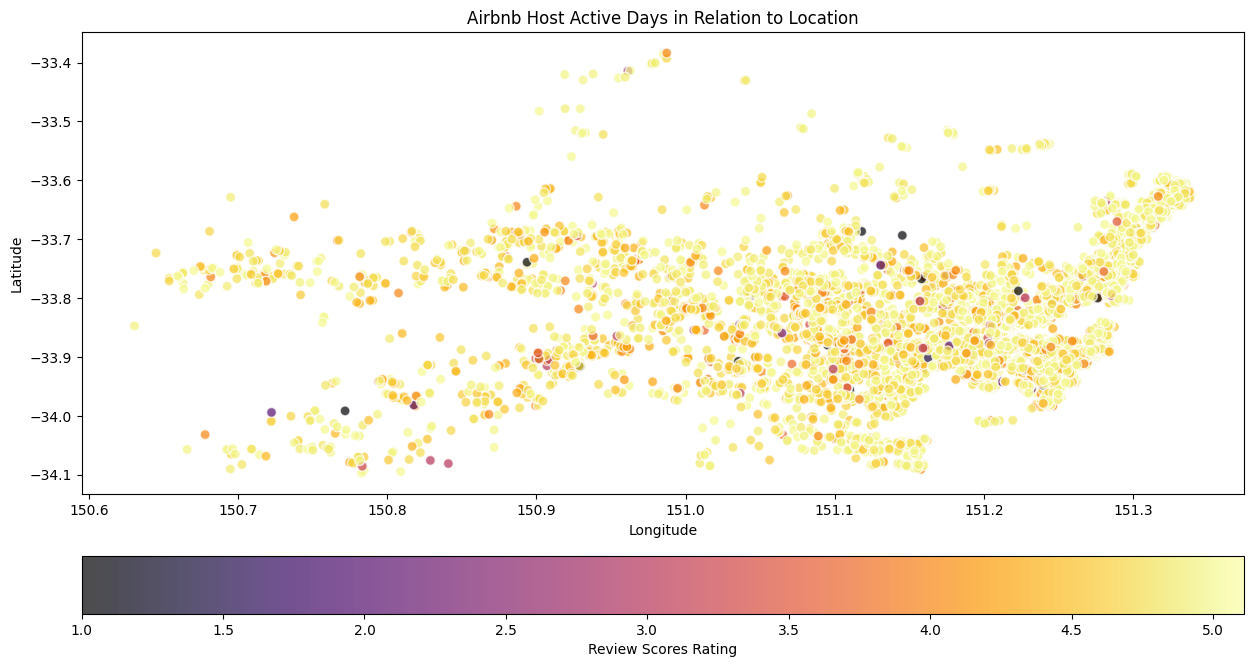

In [40]:
fig, ax = plt.subplots(figsize=(15, 8))

scatter = ax.scatter(
    listing_data['longitude'], 
    listing_data['latitude'], 
    c=listing_data['review_scores_rating'], 
    cmap='inferno', 
    s=50, 
    alpha=0.7, 
    edgecolors='w'
)

cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, ax=ax)
cbar.set_label('Review Scores Rating')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Airbnb Host Active Days in Relation to Location')
plt.show()

From the graph, the overwhelming positive ratings of Sydney airbnbs are seen again, with most plots being colored light orange to yellow. Some bright orange plots are contrastingly seen sprinkled all around the city without any distinct pattern. However, they are mostly seen concentrated around the city center and expands slightly around the west and east areas. Even so, coastal and southern areas are colored slightly brighter in comparison, showing an even more positive spread. From the previous location graphs, this makes sense as seaside properties tend to be listed by hosts that have been in the industry for longer, which as established before to show correlation with higher reviews, and also has plot trends of higher prices.

##### Final Correlation Overview

Now let's calculate each of their correlation to review scores and see what affects the ratings most

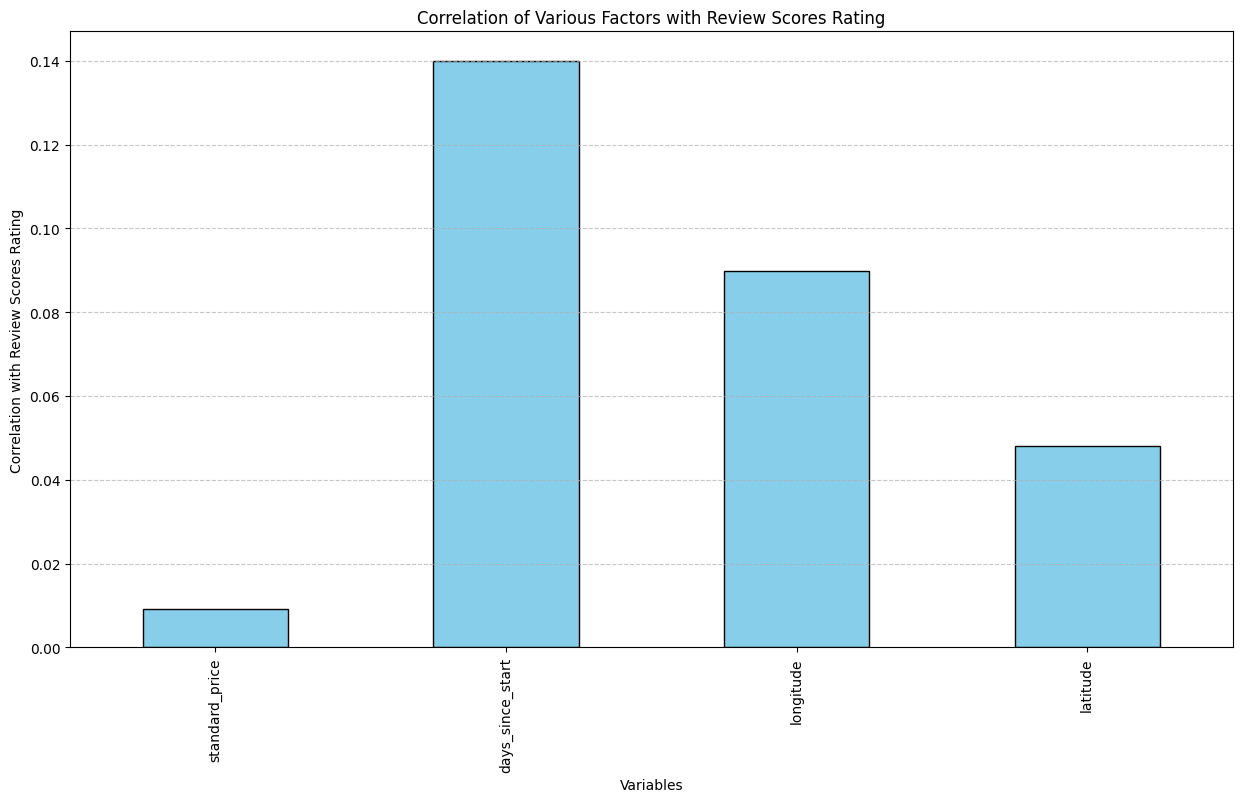

In [41]:
data_filtered = pd.DataFrame({
    'review_scores_rating': listing_data['review_scores_rating'],
    'standard_price': listing_data['standard_price'],
    'days_since_start': listing_data['days_since_start'],
    'longitude': listing_data['longitude'],
    'latitude': listing_data['latitude']
})

correlation_matrix = data_filtered.corr()

fig, ax = plt.subplots(figsize=(15, 8))
correlations = correlation_matrix['review_scores_rating'].drop('review_scores_rating')
correlations.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Variables')
ax.set_ylabel('Correlation with Review Scores Rating')
ax.set_title('Correlation of Various Factors with Review Scores Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


A more positive or increasing longitude refers to an eastern location, whereas a more negative or decreasing longitude refers to a western location.

A more positive or increasing latitude refers to a more northern location, whereas a more negative or decreasing latitude refers to a more southern location.

In conclusion, how long a host has been in the industry affects the review scores most, with a 0.14 value. Whereas longitude and latitude does affect and correlate with ratings, it is not by much and perhaps just refer to the more northern and eastern points characteristics of Sydney beaches, which seen from previous analysis, are areas that have higher prices to book, but has a pattern of more active hosts and better review scores. With a value of 0.01, prices are the factor that affects review scores least out of the three. Their correlation are extremely microscopic that it is almost unrelated. Paying more for an airbnb doesn't guarantee a better experience or quality.

Overall, as a customer on budget, there's no reason to sacrifice more money to book Sydney airbnbs. Instead, further focus should be emphasized on finding a more active host and a more northeastern location. For a more financially flexible customer that's willing to spend more, finding a coastal/seaside airbnb with an active host is the most ideal method to apply for finding the best airbnb. Lastly, booking an airbnb from hosts that have been in the industry for 15 years from now is the jackpot. From the hosts' active days in relation to location graph, you can see that their properties listings are near the beaches. Apart from that ideal location, they provide extremely reasonable prices with the highest average reviews.